## Drive mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Mon Aug  2 01:58:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install konlpy
!pip install keras-rectified-adam

     |████████████████████████████████| 19.4 MB 192 kB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 448 kB 57.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-py3-none-any.whl size=9017 sha256=881d47ea463e911def088adde40e9f0bd4601be7e5fbedd1fc7798c5fe76a798
  Stored in directory: /root/.cache/pip/wheels/52/1d/66/374c85b327ea412af5301b4811088408d9764314d6cfb8f127
Successfully built keras-rectified-adam


In [5]:
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Concatenate, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models

from keras_radam import RAdam
from tensorflow.keras.optimizers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from konlpy.tag import Okt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim
import os
import re

In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/gh/CNNForSentenceClassification/data_in/train_spacing.csv')
test_df = pd.read_csv('/content/drive/MyDrive/gh/CNNForSentenceClassification/data_in/test_spacing.csv')

In [7]:
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

In [8]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt=Okt()
cl_train =[]

for review in train_df['document']:
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review)
    word_review = okt.morphs(review_text, stem=True,norm=True)
    word_review = [token for token in word_review if not token in stop_words]
    cl_train.append(' '.join(word_review))

train_df["cl_document"] = cl_train

In [9]:
cl_test =[]
for review in test_df['document']:
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]","",review)
    word_review = okt.morphs(review_text, stem=True,norm=True)
    word_review = [token for token in word_review if not token in stop_words]
    cl_test.append(' '.join(word_review))

test_df["cl_document"] = cl_test

In [10]:
vocab_size = [] 

for line in train_df['cl_document']:
    vocab_size.extend(str(line).split())
len(set(vocab_size))

39933

In [11]:
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(train_df['cl_document'])
word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(train_df['cl_document'])
test_seq = tokenizer.texts_to_sequences(test_df['cl_document'])
train_pad = pad_sequences(train_seq, maxlen=40, padding='pre', truncating='pre')
test_pad = pad_sequences(test_seq, maxlen=40, padding='pre', truncating='pre')

In [12]:
import numpy as np

def load_dic(dic_file) :
  embeddings_index = dict()
  f = open(dic_file)
  for i, line in enumerate(f):
    if i == 0 : continue
    try :
      values = line.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
    except :
      print(i)
      print(values)
  f.close()

  return embeddings_index

embeddings_index = load_dic("/content/drive/MyDrive/gh/CNNForSentenceClassification/embeddings/fasttext.vec")


In [13]:
def gen_embedding_matrix(vocab, embeddings_index, embedding_size) :
  vocabulary_size = len(vocab)+1

  embedding_matrix = np.zeros((vocabulary_size, embedding_size))
  for word, index in vocab.items():
      if index > vocabulary_size - 1:
          break
      else:
          embedding_vector = embeddings_index.get(word)
          if embedding_vector is not None:
              embedding_matrix[index] = embedding_vector
  return embedding_matrix

embedding_matrix = gen_embedding_matrix(word_index, embeddings_index, embedding_size=100)
embed_size = embedding_matrix.shape[1]


In [14]:
# set parameters

vocab_size = len(set(word_index))+1
maxlen = 40
batch_size = 32
embedding_dims = 100
epochs = 32
VALID_SPLIT = 0.1

In [15]:
embedding_layer1 = Embedding(vocab_size,
                            embedding_dims,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=True,
)
embedding_layer2 = Embedding(vocab_size,
                            embedding_dims,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=True,
)
embedding_layer3 = Embedding(vocab_size,
                            embedding_dims,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=True,
)

In [16]:
print('>>> Build model >>>')

# https://keras.io/layers/embeddings/
model_a = Sequential()
model_a.add(embedding_layer1)
model_a.add(Conv1D(128, 5, activation='relu'))
model_a.add(MaxPooling1D())

model_b = Sequential()
model_b.add(embedding_layer2)
model_b.add(Conv1D(128, 3, activation='relu'))
model_b.add(MaxPooling1D())

model_c = Sequential()
model_c.add(embedding_layer3)
model_c.add(Conv1D(128, 4, activation='relu'))
model_c.add(MaxPooling1D())


conc = concatenate([model_a.output, model_b.output, model_c.output], axis = 1)
out = Flatten()(conc)
out = Dense(128, activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(128, activation='relu')(out)
out = Dropout(0.2)(out)
out = Dense(1, activation='sigmoid')(out)

model = Model(inputs = [model_a.input, model_b.input, model_c.input], outputs = out)
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Adam
# Nadam
# Radam

>>> Build model >>>
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1_input (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_2_input (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      3993500     embedding_input[0][0]            
__________________________________________________________________________

In [17]:
y_test=test_df['label'].astype('int32')

In [18]:
model_name = 'cnn_v3'
DATA_OUT_PATH = "/content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/"
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, 
                              monitor='val_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True)

/content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/cnn_v3 -- Folder already exists 



In [19]:
train_input = [train_pad, train_pad, train_pad]
test_input = [test_pad,test_pad,test_pad]
labels = train_df['label'].astype('int32')


history = model.fit(train_input, 
                    labels, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split = VALID_SPLIT,
                    callbacks=[earlystop_callback, cp_callback])

Epoch 1/32
528/528 [==============================] - 51s 64ms/step - loss: 0.4130 - accuracy: 0.8066 - val_loss: 0.3390 - val_accuracy: 0.8512

Epoch 00001: val_accuracy improved from -inf to 0.85120, saving model to /content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/cnn_v3/weights.h5
Epoch 2/32
528/528 [==============================] - 34s 64ms/step - loss: 0.2866 - accuracy: 0.8794 - val_loss: 0.3429 - val_accuracy: 0.8539

Epoch 00002: val_accuracy improved from 0.85120 to 0.85387, saving model to /content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/cnn_v3/weights.h5
Epoch 3/32
528/528 [==============================] - 33s 62ms/step - loss: 0.1962 - accuracy: 0.9217 - val_loss: 0.4060 - val_accuracy: 0.8461

Epoch 00003: val_accuracy did not improve from 0.85387
Epoch 4/32
528/528 [==============================] - 33s 63ms/step - loss: 0.1188 - accuracy: 0.9541 - val_loss: 0.5253 - val_accuracy: 0.8384

Epoch 00004: val_accuracy did not improve from 0.853

In [20]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

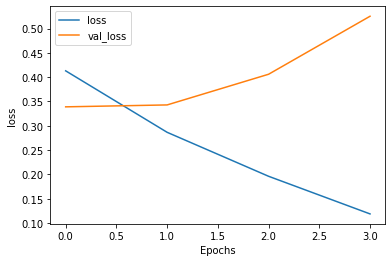

In [21]:
plot_graphs(history, 'loss')

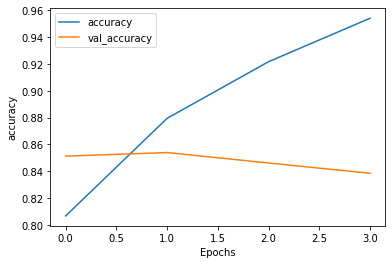

In [22]:
plot_graphs(history, 'accuracy')

In [23]:
DATA_OUT_PATH = "/content/drive/MyDrive/gh/CNNForSentenceClassification/data_out/"
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름

In [24]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [25]:
model.evaluate(test_input, y_test)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.3532 - accuracy: 0.8502


[0.353181928396225, 0.8501999974250793]